In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
from math import ceil
from scipy.fftpack import dct, idct

def preprocess_image(image_path, resize_dim=(512, 512), use_grayscale=False, denoise=True):
    original_image = cv2.imread(image_path)
    if original_image is None:
        raise ValueError("Gambar tidak ditemukan!")
    
    image = original_image.copy()
    
    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)
            
    image = cv2.resize(image, resize_dim)    
    
    if use_grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Gambar dikonversi ke grayscale.")
        
    img_shape = image.shape
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    std_intensity = np.std(image)
    mean_intensity = np.mean(image)
    
    print(f"Ukuran Gambar: {img_shape}")
    print(f"Min Intensitas Piksel: {min_intensity}")
    print(f"Max Intensitas Piksel: {max_intensity}")
    print(f"Standard Deviasi Intensitas Piksel: {std_intensity:.2f}")
    print(f"Rata-rata Intensitas Piksel: {mean_intensity:.2f}")
    
    plt.figure(figsize=(16, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Gambar Asli")
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if not use_grayscale else image, cmap='gray')
    plt.title("Gambar Setelah Preprocessing")
    plt.axis("off")
    
    plt.show()
    
    return image

def calculate_psnr(original_path, stego_path):
    original = cv2.imread(original_path)
    stego = cv2.imread(stego_path)

    mse = np.mean((original - stego) ** 2)
    if mse == 0:
        return 100.0
    PIXEL_MAX = 255.0
    psnr = 10 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

def embed_message_dct(image_path, message, output_path):
    image = preprocess_image(image_path, use_grayscale=False)    
    
    message += "#"  
    message_bits = ''.join(format(ord(c), '08b') for c in message)
    
    rows, cols, channels = image.shape
    max_bits = (rows // 8) * (cols // 8)  
    
    if len(message_bits) > max_bits:
        raise ValueError("Pesan terlalu panjang untuk disisipkan dalam gambar!")
    
    stego_image = image.copy()
    bit_index = 0

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            if bit_index >= len(message_bits):
                break

            block = stego_image[i:i+8, j:j+8, 0]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            
            if message_bits[bit_index] == '1':
                dct_block[4, 3] = np.ceil(dct_block[4, 3] / 2) * 2 + 1
            else:
                dct_block[4, 3] = np.ceil(dct_block[4, 3] / 2) * 2

            bit_index += 1

            idct_block = idct(idct(dct_block.T, norm='ortho').T, norm='ortho')
            stego_image[i:i+8, j:j+8, 0] = np.uint8(np.clip(idct_block, 0, 255))

        if bit_index >= len(message_bits):
            break

    cv2.imwrite(output_path, stego_image)


def extract_message_dct(stego_image_path):
    image = preprocess_image(stego_image_path, use_grayscale=False)
    rows, cols, _ = image.shape
    extracted_bits = ''
    extracted_message = ''
    
    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            block = image[i:i+8, j:j+8, 0] 
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            coef_value = dct_block[4, 3]

            bit = '1' if int(abs(round(coef_value))) % 2 == 1 else '0'
            extracted_bits += bit
            
            if len(extracted_bits) >= 8:
                byte = extracted_bits[:8]
                extracted_bits = extracted_bits[8:]  
                char = chr(int(byte, 2))
                
                if 32 <= ord(char) <= 126 or char == '#':
                    extracted_message += char
                    if char == '#':  
                        return extracted_message[:-1]
                else:
                    return extracted_message

    return extracted_message


Ukuran Gambar: (512, 512, 3)
Min Intensitas Piksel: 0
Max Intensitas Piksel: 255
Standard Deviasi Intensitas Piksel: 67.06
Rata-rata Intensitas Piksel: 227.22


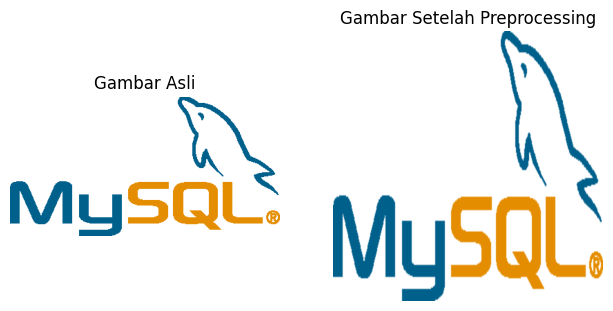

In [4]:
embed_message_dct("Citra Label Watermark.png", 
                  "Dokumen Rahasia: Kontrak eksklusif artis X dengan agensi selama 7 tahun. Tanggal debut: 15-07-2025.", 
                  "stego_dct.png")

Ukuran Gambar: (512, 512, 3)
Min Intensitas Piksel: 0
Max Intensitas Piksel: 255
Standard Deviasi Intensitas Piksel: 67.06
Rata-rata Intensitas Piksel: 227.21


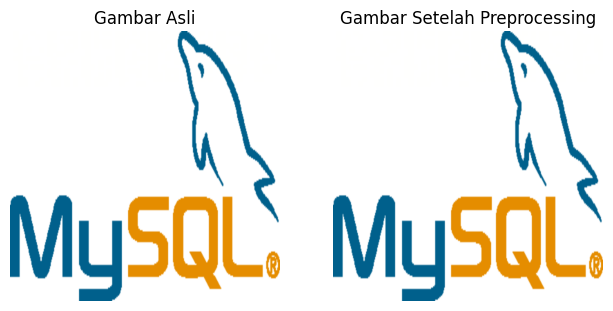

[PESAN]
 


In [5]:
extracted_text = extract_message_dct("stego_dct.png")
print("[PESAN]\n", extracted_text)

In [6]:
user_data = pd.read_csv('user_data.csv')
def login_ui():
    clear_output()
    
    username_input = widgets.Text(description="Username:")
    password_input = widgets.Password(description="Password:")
    login_button = widgets.Button(description="Login", button_style='success')
    output = widgets.Output()

    def handle_login(btn):
        global username, password
        username = username_input.value.strip()
        password = password_input.value.strip()
        user_row = user_data[(user_data['username'] == username) & (user_data['password'] == password)]

        if username in user_data['username'].values:
            username = username
            password = password
            output.clear_output()
            with output:
                print(f"Login berhasil sebagai {username}")
                show_gallery(username, password)
        else:
            output.clear_output()
            with output:
                print("Username tidak ditemukan!")


    login_button.on_click(handle_login)
    display(widgets.VBox([
    widgets.Label("Masukkan Username dan Password:"),
    username_input,
    password_input,
    login_button,
    output
]))


def show_gallery(username, password):
    clear_output()        
    user_role = user_data[user_data['username'] == username]['role'].values[0]        
    user_images = user_data[user_data['username'] == username]['url_file'].dropna().tolist()    
    user_images = [image for image in user_images if image.endswith('stegoDCT.png')]

    
    if not user_images:
        print("Tidak ada gambar untuk ditampilkan.")
        return

    image_widgets = []
    for url_file in user_images:
        try:            
            url_file = url_file.replace('\\', os.sep)            
                        
            abs_path = os.path.abspath(url_file)            
            with open(abs_path, "rb") as f:
                img_data = f.read()
                image_widget = widgets.Image(
                    value=img_data,
                    format='png',
                    layout=widgets.Layout(width='200px', height='200px', object_fit='contain', background_color='#fff')
                )

            btn_extract = widgets.Button(description="Ekstrak Pesan", layout=widgets.Layout(width='200px'))
            btn_delete = widgets.Button(description="Hapus", layout=widgets.Layout(width='200px'), button_style='danger')
            output_box = widgets.Output()  
            img_box = widgets.VBox([image_widget, btn_extract, btn_delete, output_box],
                layout=widgets.Layout(align_items='center', width='220px')
            )

            def on_extract(btn, path=url_file, popup_box=output_box):
                try:
                    popup_box.clear_output()
                    message = extract_message_dct(path)
                    
                    psnr_value = user_data.loc[user_data['url_file'] == path.replace('/', '\\'), 'psnr'].values[0]
                    psnr_formatted = f"{psnr_value:.2f}"
                    created_at = user_data.loc[user_data['url_file'] == path.replace('/', '\\'), 'created_at'].values[0]

                    with popup_box:
                        display(widgets.HTML(
                            f"""                            
                                <div id="popup-card" style="
                                    background-color: #f0f8ff;
                                    padding: 15px;
                                    border-left:5px solid #8ec4f3;
                                    border-radius: 10px;
                                    box-shadow: 0 4px 8px rgba(0,0,0,0.2);
                                    margin-top: 10px;
                                    position: relative;
                                ">
                                    <span onclick="this.parentElement.style.display='none';" style="
                                        position: absolute;
                                        top: 10px;
                                        right: 15px;
                                        font-weight: bold;
                                        color: #a00;
                                        cursor: pointer;
                                        font-size: 18px;
                                    ">×</span>
                                    <b>📦 Pesan</b><br><p style="color: #575d61; font-size: 8px;">{created_at}</p>
                                    <p>{message}<br></p>
                                    <p style="color: #575d61; font-size: 10px; text-align: right;"><strong>🔍 PSNR:</strong> {psnr_formatted} dB <br>{get_psnr_category(psnr_value)}</p>
                                </div>
                            """
                        ))
                except Exception as e:
                    popup_box.clear_output()
                    with popup_box:
                        display(widgets.HTML(
                            f"""
                            <div style='background-color:#ffe6e6; padding:10px; border-left:5px solid #cc0000; border-radius:5px;'>
                                <strong>❌ Gagal mengekstrak pesan:</strong><br>{str(e)}
                            </div>
                            """
                        ))

            def get_psnr_category(psnr):
                if psnr < 20:
                    return "☹️ Kualitas Citra Rendah"
                elif 20 <= psnr < 30:
                    return "😑 Kualitas Citra Cukup Baik"
                elif 30 <= psnr < 40:
                    return "☺️ Kualitas Citra Baik"
                else:
                    return "🤩 Kualitas Citra Luar Biasa"

            btn_extract.on_click(lambda btn, p=url_file, pop=output_box: on_extract(btn, p, pop))

            def on_delete(btn, path=url_file):
                rel_path = os.path.relpath(path, os.getcwd()).replace('/', '\\')
                user_data.drop(user_data[(user_data['username'] == username) & (user_data['url_file'] == rel_path)].index, inplace=True)
                user_data.to_csv('user_data.csv', index=False)
                print(f"Gambar {path} dihapus.")
                show_gallery(username, password) 
            
            btn_delete.on_click(lambda btn, p=url_file: on_delete(btn, p))

            img_box.children = [image_widget, btn_extract, btn_delete, output_box]
            image_widgets.append(img_box)

        except Exception as e:
            print(f"Error saat menampilkan gambar: {e}")
            pass
    
    upload_button = widgets.FileUpload(accept='image/*', multiple=False)
    message_text = widgets.Textarea(description="Pesan:", layout=widgets.Layout(width='400px', height='100px'))
    submit_button = widgets.Button(description="Sisipkan Pesan", button_style='info')
    output_embed = widgets.Output()

    def handle_embed(btn):
        global user_data
        output_embed.clear_output()
        if upload_button.value:
            uploaded_file = list(upload_button.value)[0]
            content = uploaded_file['content']
            filename = uploaded_file['name']
        
            role_folder = user_role 
            filepath = os.path.join(f"DATASET{os.sep}{role_folder}{os.sep}{username}", f"_{filename}")
            
            os.makedirs(os.path.dirname(filepath), exist_ok=True) 
            with open(filepath, 'wb') as f:
                f.write(content)
            
            stego_filename = filename.rsplit('.', 1)[0] + '_stegoDCT.png'
            stego_path = os.path.join(f"DATASET{os.sep}{role_folder}{os.sep}{username}", stego_filename)

            try:                
                embed_message_dct(filepath, message_text.value, stego_path)                                                
                psnr_value = calculate_psnr(filepath, stego_path)                
                os.remove(filepath)
                                            
                new_id = user_data['id'].max() + 1 if not user_data.empty else 1
                date = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
                new_row = {
                    'id': new_id,
                    'username': username,
                    'password': password,
                    'role': user_role,
                    'url_file': stego_path.replace('/', '\\'),
                    'psnr': round(psnr_value, 2),
                    'created_at': date
                }
                user_data = pd.concat([user_data, pd.DataFrame([new_row])], ignore_index=True)
                user_data.to_csv('user_data.csv', index=False)
                
                with output_embed:
                    print("Pesan berhasil disisipkan dan gambar disimpan.")
                show_gallery(username, password) 
            except Exception as e:
                with output_embed:
                    print("Gagal menyisipkan pesan:", str(e))


    submit_button.on_click(handle_embed)

    display(widgets.HTML(f"<h3>Galeri untuk: {username}</h3>"))    
    rows = ceil(len(image_widgets) / 4)
    for i in range(rows):
        start = i * 4
        end = start + 4
        display(widgets.HBox(image_widgets[start:end]))

    display(widgets.HTML("<hr><b>Upload Gambar Baru + Pesan:</b>"))
    display(widgets.VBox([upload_button, message_text, submit_button, output_embed]))

login_ui()